In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_json('arxiv_cs_metadata_new.json',lines=True)
#(402168, 10)
print(df.shape)
print(df.head())
print(df.info())
#comments     242500 non-null  object
#journal-ref  40150 non-null   object
# doi          53043 non-null   object
print(df.describe())
# df.dropna(inplace=True)
#(15210, 10)
#15,000 papers * 5 MB/paper = 75,000 MB or 75 GB. min if we use all the pages in the paper
#ARE COMMENTS RELEVANT? Use it to filter amount of pages so we dont have a huge amount of data
#but the data size is dependent on the images and other media
print(df['comments'])
print(df['update_date'])
#journals are relevant
#doi's for citations!
#maybe build the knowledge graph based on abstracts?
#but if we retrieve a paper and need info for it call the api to get that and then store it
#in our db
#maybe experiment with a subset and cap the data somehow
#if we get the pdf's we need ocr to extract every relevant thing
# choice of embedding model(local or api)
# choice of llm(local or api)
# create embeddings for relations and maybe search also similar relations rather than just items
# # chunking?
# plt.figure(figsize=(12, 6))
# sns.histplot(df['_time'], bins=30, kde=True)  # KDE = Kernel Density Estimate
# plt.title('Distribution of Date Column')
# plt.xlabel('Date')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))
# sns.countplot(data=df, x='categories')
# plt.title('Distribution of Category Column')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.tight_layout()
# plt.show()
# if a value in the column include cs=> it's cs
print(df['categories'].value_counts())
# we have 3893 between cs topics and other areas such as math stats, phys economics, etc
print(df['categories'].nunique())
# check embedding model max input length to chunk based on that
# use semantic or logical chunking
# overlapping chunks?
# different handling of abstracts
# embedding model for figures?
# clean of references and latex commands
# dealing with equations?
# https://orkg.org/home/R132/Computer_Sciences
# citations as a measure for interaction with a certain paper
# on my laptop llm locally up to 7b param

/Users/ayushsharma/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(669, 14)
          id              submitter  \
0  0801.0341       Michael Chertkov   
1  0803.4355     Marko A. Rodriguez   
2  0810.2434          Edward Rosten   
3  0812.4446           Peter Turney   
4  0901.3574  Christoph Benzmueller   

                                             authors  \
0                      Michael Chertkov (Los Alamos)   
1                                 Marko A. Rodriguez   
2           Edward Rosten, Reid Porter, Tom Drummond   
3  Peter D. Turney (National Research Council of ...   
4                              Christoph Benzmueller   

                                               title  \
0  Exactness of Belief Propagation for Some Graph...   
1  Grammar-Based Random Walkers in Semantic Networks   
2  Faster and better: a machine learning approach...   
3  The Latent Relation Mapping Engine: Algorithm ...   
4  Automating Access Control Logics in Simple Typ...   

                                            comments  \
0             12 pages, 1

In [2]:
# df.head().reset_index(drop=True)
df = pd.DataFrame(df)
# df.head()

# df['id'] = range(int(len(df)))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              669 non-null    object
 1   submitter       669 non-null    object
 2   authors         669 non-null    object
 3   title           669 non-null    object
 4   comments        669 non-null    object
 5   journal-ref     669 non-null    object
 6   doi             669 non-null    object
 7   report-no       669 non-null    object
 8   categories      669 non-null    object
 9   license         669 non-null    object
 10  abstract        669 non-null    object
 11  versions        669 non-null    object
 12  update_date     669 non-null    object
 13  authors_parsed  669 non-null    object
dtypes: object(14)
memory usage: 73.3+ KB


In [8]:
pwd

'/Users/ayushsharma/Documents/Semester 1/FAI/FAI_project/cs5100_researchRAG_FinalProj'

In [3]:
df['abstract'][4]

'Garg and Abadi recently proved that prominent access control logics can be\ntranslated in a sound and complete way into modal logic S4. We have previously\noutlined how normal multimodal logics, including monomodal logics K and S4, can\nbe embedded in simple type theory (which is also known as higher-order logic)\nand we have demonstrated that the higher-order theorem prover LEO-II can\nautomate reasoning in and about them. In this paper we combine these results\nand describe a sound and complete embedding of different access control logics\nin simple type theory. Employing this framework we show that the off the shelf\ntheorem prover LEO-II can be applied to automate reasoning in prominent access\ncontrol logics.'

In [4]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

papers = df.iloc[0:10]
# concatenate title and abstract
title_abs = [f"{d['title']}{tokenizer.sep_token}{(d.get('abstract') or '')}{d.get('categories') or ''}" for _, d in papers.iterrows()]
# preprocess the input
inputs = tokenizer(title_abs, padding=True, truncation=True, return_tensors="pt", max_length=512)
result = model(**inputs)
# take the first token in the batch as the embedding
embeddings = result.last_hidden_state[:, 0, :]
embeddings = embeddings.detach().numpy()

/Users/ayushsharma/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
embeddings

array([[-0.8627601 ,  0.17539941,  0.29421818, ..., -0.03183612,
         0.582551  , -0.12368482],
       [-0.1362449 ,  0.56305933,  0.27621812, ...,  0.47176644,
         0.64069384,  0.20823073],
       [ 0.29492325,  0.39060095, -0.28535175, ..., -0.07692415,
        -0.40272176,  0.32548487],
       ...,
       [-0.61662716,  1.2275038 ,  0.5693554 , ...,  0.5610058 ,
         0.5074949 , -0.21436247],
       [ 0.07118641,  0.06110401,  0.78282654, ...,  0.75428396,
        -0.17231518,  0.8071019 ],
       [-0.18678024, -0.3142977 , -0.34951523, ..., -0.3193534 ,
         0.6610801 ,  0.9041364 ]], dtype=float32)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming `embeddings_df` contains the embeddings for the papers
# Let's say you have 5 papers and their embeddings are stored in embeddings_df

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)
similarity_df = pd.DataFrame(similarity_matrix, columns=df['id'][:10], index=df['id'][:10])

print("Cosine Similarity Matrix:")
print(similarity_df)

Cosine Similarity Matrix:
id         0801.0341  0803.4355  0810.2434  0812.4446  0901.3574  0902.3294  \
id                                                                            
0801.0341   1.000000   0.756055   0.635543   0.692532   0.640380   0.716765   
0803.4355   0.756055   1.000000   0.688896   0.816574   0.645025   0.700287   
0810.2434   0.635543   0.688896   1.000000   0.719330   0.559357   0.660877   
0812.4446   0.692532   0.816574   0.719330   1.000000   0.687021   0.768297   
0901.3574   0.640380   0.645025   0.559357   0.687021   1.000000   0.720295   
0902.3294   0.716765   0.700287   0.660877   0.768297   0.720295   1.000000   
0902.3635   0.761853   0.683841   0.623915   0.680489   0.774663   0.778629   
0902.3749   0.736596   0.714201   0.572402   0.675497   0.787815   0.779650   
0903.1095   0.680645   0.653191   0.544879   0.634957   0.608923   0.659668   
0910.1800   0.770396   0.804696   0.747285   0.795218   0.606622   0.671985   

id         0902.3635  090

<Axes: xlabel='id', ylabel='id'>

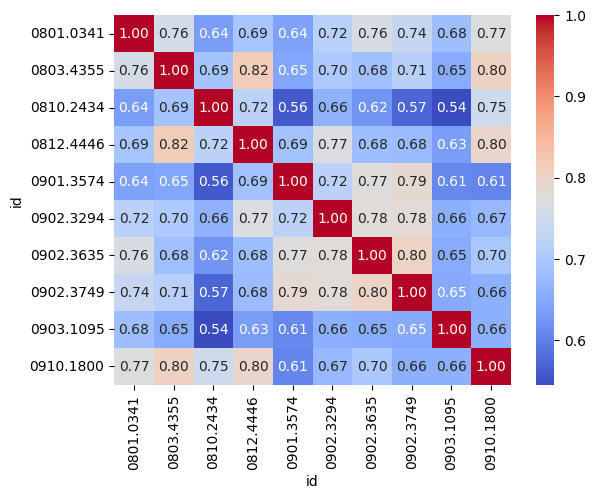

In [7]:
import seaborn as sns
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

In [13]:
def get_embedding(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    # Use the [CLS] token's representation as the embedding
    embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embedding

# Generate embedding for the researcher's prompt
prompt = "Tell me abount prominent access control logics"
prompt_embedding = get_embedding(prompt)

# Calculate cosine similarity between prompt embedding and each paper embedding
similarities = cosine_similarity(prompt_embedding, embeddings).flatten()

# Get indices of papers sorted by similarity in descending order
sorted_indices = np.argsort(-similarities)

# Rank the papers and display similarity scores
ranked_papers = [(index, similarities[index]) for index in sorted_indices]

# Print ranked papers with their similarity scores
print("Top Research Paper Matches:")
for rank, (index, score) in enumerate(ranked_papers, start=1):
    print(f"Rank {rank}: Paper {index} with similarity score {score:.4f}")

Top Research Paper Matches:
Rank 1: Paper 4 with similarity score 0.7950
Rank 2: Paper 6 with similarity score 0.6944
Rank 3: Paper 7 with similarity score 0.6868
Rank 4: Paper 3 with similarity score 0.6752
Rank 5: Paper 1 with similarity score 0.6711
Rank 6: Paper 9 with similarity score 0.6577
Rank 7: Paper 5 with similarity score 0.6405
Rank 8: Paper 2 with similarity score 0.6043
Rank 9: Paper 8 with similarity score 0.5746
Rank 10: Paper 0 with similarity score 0.5546


In [15]:
df['abstract'][4]

'Garg and Abadi recently proved that prominent access control logics can be\ntranslated in a sound and complete way into modal logic S4. We have previously\noutlined how normal multimodal logics, including monomodal logics K and S4, can\nbe embedded in simple type theory (which is also known as higher-order logic)\nand we have demonstrated that the higher-order theorem prover LEO-II can\nautomate reasoning in and about them. In this paper we combine these results\nand describe a sound and complete embedding of different access control logics\nin simple type theory. Employing this framework we show that the off the shelf\ntheorem prover LEO-II can be applied to automate reasoning in prominent access\ncontrol logics.'

In [ ]:
# from sentence_transformers import SentenceTransformer
# sentences = ["This is an example sentence", "Each sentence is converted"]

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# embeddings = model.encode(sentences)
# # print(embeddings)
